### Yolov5 object detection model

First lets get the bouning boxes for the LIDC images

In [7]:
!pip install pydicom
!pip install pylidc
!pip install torchsummary
!pip install imageio
!pip install gsutil

     |████████████████████████████████| 2.9 MB 19.3 MB/s eta 0:00:01
     |████████████████████████████████| 89 kB 11.7 MB/s eta 0:00:01
     |████████████████████████████████| 135 kB 41.0 MB/s eta 0:00:01
     |████████████████████████████████| 96 kB 7.3 MB/s  eta 0:00:01
     |████████████████████████████████| 1.4 MB 73.2 MB/s eta 0:00:01
     |████████████████████████████████| 98 kB 10.5 MB/s eta 0:00:01
  Created wheel for gsutil: filename=gsutil-5.4-py3-none-any.whl size=3715180 sha256=8795386d55b3e12cf86a8c487afa8602623e7c3e0e9f07fc45662f11b9bc3060
  Stored in directory: /root/.cache/pip/wheels/dc/7c/63/8cf44cb0431ae369e2c158cbbefa036b38bfa94bd707ab653e
  Created wheel for crcmod: filename=crcmod-1.7-cp38-cp38-linux_x86_64.whl size=36025 sha256=3783c92be20c75859d2250dd8bf4d4bf2915039a06f10a15f25ab73e75b6a27c
  Stored in directory: /root/.cache/pip/wheels/ca/5a/02/f3acf982a026f3319fb3e798a8dca2d48fafee7761788562e9
  Created wheel for gcs-oauth2-boto-plugin: filename=gcs_oauth2_bot

In [1]:
!git clone https://github.com/pieper/dicomsort.git

fatal: destination path 'dicomsort' already exists and is not an empty directory.


In [1]:
import pylidc as pl
from pylidc.utils import consensus
import pydicom as dicom
from skimage.measure import find_contours
import numpy as np
import matplotlib.pyplot as plt

In [2]:
pl.query(pl.Scan).count()
pid = 'LIDC-IDRI-0069'#'LIDC-IDRI-0001'
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id == pid).first()
scan.study_instance_uid

'1.3.6.1.4.1.14519.5.2.1.6279.6001.303241414168367763244410429787'

In [4]:
!pip install google-cloud-bigquery
!pip install --upgrade google-auth-oauthlib
!pip install --upgrade 'google-cloud-bigquery[bqstorage,pandas]'

Requirement already up-to-date: google-auth-oauthlib in /opt/conda/lib/python3.8/site-packages (0.4.6)
Requirement already up-to-date: google-cloud-bigquery[bqstorage,pandas] in /opt/conda/lib/python3.8/site-packages (2.29.0)


In [3]:
%load_ext google.cloud.bigquery

In [4]:
from google_auth_oauthlib import flow

# TODO: Uncomment the line below to set the `launch_browser` variable.
launch_browser = False
#
# The `launch_browser` boolean variable indicates if a local server is used
# as the callback URL in the auth flow. A value of `True` is recommended,
# but a local server does not work if accessing the application remotely,
# such as over SSH or from a remote Jupyter notebook.

appflow = flow.InstalledAppFlow.from_client_secrets_file(
    "client_secret_desktop.json", scopes=["https://www.googleapis.com/auth/bigquery"]
)

if launch_browser:
    appflow.run_local_server()
else:
    appflow.run_console()

credentials = appflow.credentials

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=286006984742-oetffmukptpafo18coob3vgc4f42oppi.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=8yCA4Sa6XrBN4X6HNSZMNa6lQULzXp&prompt=consent&access_type=offline


Enter the authorization code:  4/1AX4XfWhCPR5gdOqmWwx8i0GEB9JQ1MxnC7oUYuEhCel215BofZ1VQLBwLZ0


In [5]:
from google.cloud.bigquery import magics
magics.context.credentials = credentials

In [6]:
myProjectID = "positive-sector-330514"

In [7]:
%%bigquery CT_series --project=$myProjectID 

WITH
  all_lidc_ct_series AS (
  SELECT
    DISTINCT(SeriesInstanceUID),
    StudyInstanceUID,  
    PatientID,
    SliceThickness,
    ARRAY_TO_STRING(PixelSpacing,"/") as pixelspa 
  FROM
    `canceridc-data.idc_views.dicom_all`
  WHERE
    Modality = "CT"
    AND collection_id = "lidc_idri")
SELECT PatientID,SliceThickness,pixelspa,StudyInstanceUID,SeriesInstanceUID FROM
  all_lidc_ct_series
ORDER BY
  PatientID

Downloading: 100%|██████████| 1018/1018 [00:03<00:00, 261.21rows/s]


In [8]:
total_patients = len(np.unique(CT_series['PatientID']))
chosen_patients = len(np.unique(CT_series[(CT_series["SliceThickness"].astype(float)>=1.0)]['PatientID']))
print("Choosing patients with slice thickness > 1.0")
print("Total patients is {} and chosen patients are {}".format(total_patients, chosen_patients))

Choosing patients with slice thickness > 1.0
Total patients is 1010 and chosen patients are 971


In [9]:
import pandas as pd
ct_series_HR = CT_series[(CT_series["SliceThickness"].astype(float)>=1.0)]
print("Shape of the raw dataset is {}".format(ct_series_HR.shape))

Shape of the raw dataset is (979, 5)


In [10]:
to_download = []
base_gs_uri = 'gs://idc-tcia-lidc-idri/dicom/'

for i in range(ct_series_HR.shape[0]):
    to_download.append(base_gs_uri + ct_series_HR.iloc[i]['StudyInstanceUID'] + '/' + ct_series_HR.iloc[i]['SeriesInstanceUID'])

manifest_df = pd.DataFrame({"gcs":to_download},columns=["gcs"])

In [11]:
manifest_df.to_csv("gcs_paths_all.txt",header=False, index=False)
!head gcs_paths_all.txt

gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.298806137288633453246975630178/1.3.6.1.4.1.14519.5.2.1.6279.6001.179049373636438705059720603192
gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.490157381160200744295382098329/1.3.6.1.4.1.14519.5.2.1.6279.6001.619372068417051974713149104919
gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.101370605276577556143013894866/1.3.6.1.4.1.14519.5.2.1.6279.6001.170706757615202213033480003264
gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.191425307197546732281885591780/1.3.6.1.4.1.14519.5.2.1.6279.6001.323541312620128092852212458228
gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.190188259083742759886805142125/1.3.6.1.4.1.14519.5.2.1.6279.6001.129007566048223160327836686225
gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.1.14519.5.2.1.6279.6001.324680252006411183918098592500/1.3.6.1.4.1.14519.5.2.1.6279.6001.132817748896065918417924920957
gs://idc-tcia-lidc-idri/dicom/1.3.6.1.4.

In [12]:
!mkdir -p data/yolov5
!mkdir -p data/yolov5/gcsfiles
!mkdir -p data/yolov5/sorted_gcsfiles

In [15]:
from tqdm import tqdm

In [8]:
from PIL import Image
import contextlib

def save_patient_images_and_masks(patient_id, root_dir='data/yolov5'):
    scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_([patient_id]))[0]
    nodules_annotation = scan.cluster_annotations()
    with contextlib.redirect_stdout(None):
        vol = scan.to_volume()

    cmask_CT = []
    cbbox_CT = []
    masks_CT = []
    for nodule_idx, nodule in enumerate(nodules_annotation):
        cmask, cbbox, masks = consensus(nodule)
        cmask_CT.append(cmask)
        cbbox_CT.append(cbbox)
        masks_CT.append(masks)   

    CT_mask = np.zeros_like(vol)    
    nodule_num = len(cmask_CT)

    for i in range(nodule_num):
        cmask = cmask_CT[i]
        cbbox = cbbox_CT[i]
        masks = masks_CT[i]    
        CT_mask[cbbox] += cmask

    for slice_id in range(vol.shape[2]):
        image = vol[:,:,slice_id]
        mask = CT_mask[:,:,slice_id]
        image_file_name = root_dir + "/images/" + "img" + "_" + str(patient_id) + "_" + str(slice_id) + ".npz"
        mask_file_name = root_dir + "/masks/" + "mask" + "_" + str(patient_id) + "_" + str(slice_id) + ".npz"
        np.savez_compressed(image_file_name, image)
        np.savez_compressed(mask_file_name, mask)

In [9]:
root_dir = 'data/yolov5'
def patient_data_as_npz_files():
    #get patient list
    patient_list = os.listdir(data_folder)
    if not os.path.exists(root_dir):
        print("Creating directory {}".format(root_dir))
        os.makedirs(root_dir)
    if not os.path.exists(root_dir + "/images/"):
        print("Creating directory {}".format(root_dir + "/images/"))
        os.makedirs(root_dir + "/images/")
    if not os.path.exists(root_dir + "/masks/"):
        print("Creating directory {}".format(root_dir + "/masks/"))
        os.makedirs(root_dir + "/masks/")
    print("Saving patient .npz files to {}".format(root_dir))
    for i in tqdm(range(len(patient_list))):
        try:
            save_patient_images_and_masks(patient_list[i], root_dir)
        except:
            print("Error getting DICOM files for patient {}, skipping".format(patient_list[i]))

### Routine to download the DICOM images

In [10]:
download_dir = '/app/data/yolov5/gcsfiles'
sorted_dir = '/app/data/yolov5/sorted_gcsfiles/'

In [18]:
import os, shutil
import glob

if not os.path.exists(download_dir):
    print("Creating directory {}".format(download_dir))
    os.makedirs(download_dir)
else:
    print("Directory {} exists".format(download_dir))

if not os.path.exists(sorted_dir):
    print("Creating directory {}".format(sorted_dir))
    os.makedirs(sorted_dir)
else:
    print("Directory {} exists".format(sorted_dir))

#max_patients = 100 #change this later, for testing .npz files etc.   
# set start from an index
#start_patient = 50
#wrong, fix it, need to use positions not i
for i in tqdm(range(manifest_df.shape[0])):
    #wrong, fix it, need to use positions not i
    url = manifest_df.iloc[i].gcs
    download_command = "gsutil -u {} -m cp -r {} {} >/dev/null 2>&1".format(myProjectID, url, download_dir)
    os.system(download_command)
    if (i > 1) and (i % 10 == 0): # got 10 patients
       # sort the images
       # !python dicomsort/dicomsort.py -u downloaded_cohort_3 cohort_sorted_3/%PatientID/%StudyInstanceUID/%SeriesInstanceUID/%SOPInstanceUID.dcm
        sort_command = "python dicomsort/dicomsort.py -u {} {}/%PatientID/%StudyInstanceUID/%SeriesInstanceUID/%SOPInstanceUID.dcm".format(download_dir, sorted_dir)
        os.system(sort_command)
        #todo: remove the download_dir contents
        print("Cleaning up downloaded DICOM files...")
        files = glob.glob(download_dir + "/*")
        for i in tqdm(range(len(files))):
            if os.path.isdir(files[i]):
                shutil.rmtree(files[i])
        print("Saved 10 patients data. Quitting!")
        break
#         print("Saving patient data as .npz file...")
#         patient_data_as_npz_files()
        #todo: remove the sorted_dir contents
#         print("Cleaning up sorted DICOM files...")
#         files = glob.glob(sorted_dir + "/*")
#         for i in tqdm(range(len(files))):
#             if os.path.isdir(files[i]):
#                 shutil.rmtree(files[i])

  0%|          | 0/979 [00:00<?, ?it/s]

Directory data/yolov5/gcsfiles exists
Directory data/yolov5/sorted_gcsfiles/ exists


 55%|█████▍    | 6/11 [00:00<00:00, 52.06it/s]

Cleaning up downloaded DICOM files...


  1%|          | 10/979 [01:17<2:04:36,  7.72s/it]

Saved 10 patients data. Quitting!


In [11]:
import os
# this directory will be created in the downloader but never deletedn entirely, only contents would be cleared
data_folder = sorted_dir

In [12]:
#f = open ('.pylidcrc','w')            #For GCP
f = open ('/root/.pylidcrc','w')    #For Colab
f.write('[dicom]'+'\n')
f.write('path =' + data_folder +'\n')
f.write('warn = True')
f.close()

In [13]:
import os
patient_list = os.listdir(data_folder)

In [14]:
patient_list

['LIDC-IDRI-0009',
 'LIDC-IDRI-0004',
 'LIDC-IDRI-0007',
 'LIDC-IDRI-0008',
 'LIDC-IDRI-0010',
 'LIDC-IDRI-0002',
 'LIDC-IDRI-0006',
 'LIDC-IDRI-0005',
 'LIDC-IDRI-0001',
 'LIDC-IDRI-0003',
 'LIDC-IDRI-0011']

In [15]:
from PIL import Image

In [39]:
image_path = '/app/data/yolov5/train/images'
label_path = '/app/data/yolov5/train/labels'

In [40]:
!mkdir -p {image_path}
!mkdir -p {label_path}

In [41]:
import shutil
def clear_dirs(paths):
    for path in paths:
        if os.path.isdir(path):
            shutil.rmtree(path)

In [42]:
clear_dirs([image_path, label_path])

#### DEBUG code

In [37]:
# import matplotlib.patches as patches
# import imageio
# cmask_CT = []
# cbbox_CT = []
# masks_CT = []
# for nodule_idx, nodule in enumerate(nodules_annotation):
#     cmask, cbbox, masks = consensus(nodule)
#     cmask_CT.append(cmask)
#     cbbox_CT.append(cbbox)
#     masks_CT.append(masks)   
    
# nodule_num = len(cmask_CT)
# plt.figure(figsize=(8*3,8*nodule_num))
# for i in range(nodule_num):
#     cmask = cmask_CT[i]
#     cbbox = cbbox_CT[i]
#     masks = masks_CT[i]
#     #the middle slice
#     k = int(0.5*(cbbox[2].stop - cbbox[2].start))
#     k_slice = k + cbbox[2].start
#     ax = plt.subplot(nodule_num,3,1+i*3)
#     #save this whole image for the YoloV5 object detection training
#     plt.imshow(vol[:,:,k_slice],cmap='gray')
#     plt.clim(vmin=-1350,vmax=-150)
#     image_filename = "{}_{}.jpg".format(patient_id, i)
#     print("Saving image to file {}".format(image_path + "/" + image_filename))
#     imageio.imwrite(image_path + "/" + image_filename, vol[:,:,k_slice])
#     #img = Image.fromarray(vol[:,:,k_slice]).convert('RGB')
    
#     #img.save(image_path + "/" + image_filename)
    
#     x,y,z = cbbox
#     rect = patches.Rectangle((y.start, x.start), (y.stop-y.start), (x.stop-x.start), linewidth=1, edgecolor='r', facecolor='none')
#     ax.add_patch(rect)
#     #normalized coordinates
#     c = 0 #there is only one class, the 'nodule'
#     center_x = y.start / vol[:,:,k_slice].shape[0]
#     center_y = x.start / vol[:,:,k_slice].shape[1]
#     width = (y.stop-y.start) / vol[:,:,k_slice].shape[0]
#     height = (x.stop-x.start) / vol[:,:,k_slice].shape[0]
    
#     #save this as the label for the image for the YoloV5 object detection training
#     print("Yolov5 formatted labels are = {} {} {} {} {}".format(c, center_x, center_y, width, height))
#     label = "{} {} {} {} {}".format(c, center_x, center_y, width, height)
#     label_filename = "{}_{}.txt".format(patient_id, i)
    
#     f = open(label_path + "/" + label_filename, "a")
#     f.write(label)
#     f.close()
    
#     plt.subplot(nodule_num,3,2+i*3)
#     CT_mask = np.zeros_like(vol)
#     CT_mask[cbbox] = cmask
    

#     plt.imshow(CT_mask[:,:,k_slice])

#     plt.subplot(nodule_num,3,3+i*3)
#     #save this image and the mask for segmentation model
#     plt.imshow(vol[cbbox][:,:,k],cmap='gray')
#     # Plot the annotation contours for the kth slice.
#     colors = ['r', 'g', 'b', 'y']
#     for j in range(len(masks)):
#         for c in find_contours(masks[j][:,:,k].astype(float), 0.5):
#             label = "Annotation %d" % (j+1)
#             plt.plot(c[:,1], c[:,0], colors[j], label=label)

#     # Plot the 50% consensus contour for the kth slice.
#     for c in find_contours(cmask[:,:,k].astype(float), 0.5):
#         plt.plot(c[:,1], c[:,0], '--k', label='50% Consensus')

In [16]:
patient_id = ['LIDC-IDRI-0009']
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_([patient_id]))[0]
nodules_annotation = scan.cluster_annotations()
with contextlib.redirect_stdout(None):
    vol = scan.to_volume()

In [17]:
nodules_annotation

[[Annotation(id=136,scan_id=20)], [Annotation(id=137,scan_id=20)]]

In [18]:
cmask, cbbox, masks = consensus(nodules_annotation[0])
# cmask_CT.append(cmask)
# cbbox_CT.append(cbbox)
# masks_CT.append(masks) 

In [19]:
cmask.shape

(9, 10, 3)

In [20]:
cbbox

(slice(331, 340, None), slice(198, 208, None), slice(102, 105, None))

In [21]:
z_index = 0
contours = find_contours(cmask[:,:,z_index].astype(float), 0.5)

x = 1.5, y = 0.5, w = 7.0, h= 6.0


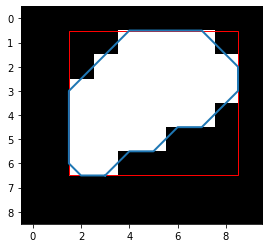

In [22]:
import matplotlib.patches as patches
img = cmask[:,:,z_index]
fig, ax = plt.subplots()
ax.imshow(img, cmap=plt.cm.gray)

minx = []
miny = []
maxx = []
maxy = []

for contour in contours:
    ax.plot(contour[:, 1], contour[:, 0], linewidth=2)
    minx.append(np.min(contour[:,1]))
    maxx.append(np.max(contour[:,1]))
    miny.append(np.min(contour[:,0]))
    maxy.append(np.max(contour[:,0]))
if len(minx) > 0:
    x,y,w,h = np.min(minx), np.min(miny), np.max(maxx) - np.min(minx), np.max(maxy)-np.min(miny)
    print("x = {}, y = {}, w = {}, h= {}".format(x,y,w,h))
    rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

In [23]:
cmask_CT = []
cbbox_CT = []
masks_CT = []
for nodule_idx, nodule in enumerate(nodules_annotation):
    cmask, cbbox, masks = consensus(nodule)
    cmask_CT.append(cmask)
    cbbox_CT.append(cbbox)
    masks_CT.append(masks)   

CT_mask = np.zeros_like(vol)    
nodule_num = len(cmask_CT)

for i in range(nodule_num):
    cmask = cmask_CT[i]
    cbbox = cbbox_CT[i]
    masks = masks_CT[i]    
    CT_mask[cbbox] += cmask
    #for each slice generate image and bounding box
    #get_bounding_box(CT_mask[:,:,cbbox[2]])
    

In [24]:
CT_mask[:,:,cbbox[2]].shape

(512, 512, 4)

In [25]:
import matplotlib.patches as patches
def get_bounding_box(img):
    minx = []
    miny = []
    maxx = []
    maxy = []
    contours = find_contours(img.astype(float), 0.5)
    print("Length of contours = ", len(contours))
    for contour in contours:
        minx.append(np.min(contour[:,1]))
        maxx.append(np.max(contour[:,1]))
        miny.append(np.min(contour[:,0]))
        maxy.append(np.max(contour[:,0]))
    if len(minx) > 0:
        x,y,w,h = np.min(minx), np.min(miny), np.max(maxx) - np.min(minx), np.max(maxy)-np.min(miny)
        return x,y,w,h
    else:
        return None,None,None,None
    
def plot_bounding_box(img):
    fig, ax = plt.subplots()
    ax.imshow(img, cmap=plt.cm.gray)
    
    x,y,w,h = get_bounding_box(img)
    if x is not None:
        print("x = {}, y = {}, w = {}, h= {}".format(x,y,w,h))
        rect = patches.Rectangle((x, y), w, h, linewidth=1, edgecolor='r', facecolor='none')
        ax.add_patch(rect)

Length of contours =  1
x = 198.5, y = 332.5, w = 6.0, h= 5.0


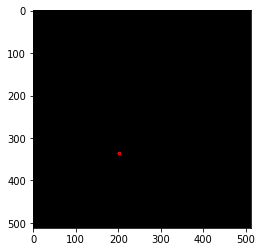

In [26]:
i = 0
#CT_mask[:,:,cbbox_CT[i][2]].shape
plot_bounding_box(CT_mask[:,:,cbbox_CT[i][2]][:,:,2])

Length of contours =  1
x = 300.5, y = 320.5, w = 5.0, h= 7.0


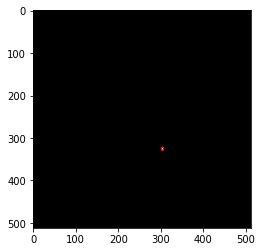

In [27]:
k = int(0.5*(cbbox[2].stop - cbbox[2].start))
k_slice = k + cbbox[2].start
im = CT_mask[:,:,k_slice]
plot_bounding_box(im)

In [43]:
import os
import contextlib
import imageio
patient_list = os.listdir(data_folder)


def save_image_and_label(patient_id):
    scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_([patient_id]))[0]
    nodules_annotation = scan.cluster_annotations()
    with contextlib.redirect_stdout(None):
        vol = scan.to_volume()

    cmask_CT = []
    cbbox_CT = []
    masks_CT = []
    for nodule_idx, nodule in enumerate(nodules_annotation):
        cmask, cbbox, masks = consensus(nodule)
        cmask_CT.append(cmask)
        cbbox_CT.append(cbbox)
        masks_CT.append(masks)
    CT_mask = np.zeros_like(vol)    
    nodule_num = len(cmask_CT)
    print("Number of nodules for patient {} is {}".format(patient_id, nodule_num))
    
    for i in range(nodule_num):
        cmask = cmask_CT[i]
        cbbox = cbbox_CT[i]
        masks = masks_CT[i]
        CT_mask[cbbox] += cmask
        #the middle slice
#         k = int(0.5*(cbbox[2].stop - cbbox[2].start))
#         k_slice = k + cbbox[2].start
        #ax = plt.subplot(nodule_num,3,1+i*3)
        #save this whole image for the YoloV5 object detection training
        #plt.imshow(vol[:,:,k_slice],cmap='gray')
        #plt.clim(vmin=-1350,vmax=-150)
        for k_slice in np.arange(cbbox[2].start, cbbox[2].stop):
            
            im = vol[:,:,k_slice]
            
            msk = CT_mask[:,:,k_slice]

            #x,y,z = cbbox
            x,y,w,h = get_bounding_box(msk)

            
            if x is not None:
                image_filename = "{}_{}_{}.jpg".format(patient_id, i, k_slice)
                print("Saving image to file {}".format(image_path + "/" + image_filename))
                imageio.imwrite(image_path + "/" + image_filename, im)
                
                
                center_x = (x + ((w)/2))/512
                center_y = (y + ((h)/2))/512
                width = w/512
                height = h/512
                
                c = 0 #there is only one class, the 'nodule'
#                 c_width = y.stop - y.start
#                 c_height = x.stop - x.start
#                 center_x = (y.start + ((y.stop - y.start)/2))/512
#                 center_y = (x.start + ((x.stop - x.start)/2))/512
#                 width = c_width / vol[:,:,k_slice].shape[0]
#                 height = c_height / vol[:,:,k_slice].shape[1]

                #save this as the label for the image for the YoloV5 object detection training
                print("Yolov5 formatted labels are = {} {} {} {} {}".format(c, center_x, center_y, width, height))
                label = "{} {} {} {} {}".format(c, center_x, center_y, width, height)
                label_filename = "{}_{}_{}.txt".format(patient_id, i, k_slice)

                f = open(label_path + "/" + label_filename, "a")
                f.write(label)
                f.close()

        #plt.subplot(nodule_num,3,2+i*3)
#         CT_mask = np.zeros_like(vol)
#         CT_mask[cbbox] = cmask


#         plt.imshow(CT_mask[:,:,k_slice])

#         plt.subplot(nodule_num,3,3+i*3)
#         #save this image and the mask for segmentation model
#         plt.imshow(vol[cbbox][:,:,k],cmap='gray')
#         # Plot the annotation contours for the kth slice.
#         colors = ['r', 'g', 'b', 'y']
#         for j in range(len(masks)):
#             for c in find_contours(masks[j][:,:,k].astype(float), 0.5):
#                 label = "Annotation %d" % (j+1)
#                 plt.plot(c[:,1], c[:,0], colors[j], label=label)

#         # Plot the 50% consensus contour for the kth slice.
#         for c in find_contours(cmask[:,:,k].astype(float), 0.5):
#             plt.plot(c[:,1], c[:,0], '--k', label='50% Consensus')

In [44]:
for patient in patient_list:
    if not os.path.exists(image_path):
        print("Creating directory {}".format(image_path))
        os.makedirs(image_path)
    if not os.path.exists(label_path):
        print("Creating directory {}".format(label_path))
        os.makedirs(label_path)
    save_image_and_label(patient)

Creating directory /app/data/yolov5/train/images
Creating directory /app/data/yolov5/train/labels


Lossy conversion from int16 to uint8. Range [-3024, 1239]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1237]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1184]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1266]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1276]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1274]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1272]. Convert image to uint8 prior to saving to suppress this warning.


Number of nodules for patient LIDC-IDRI-0009 is 2
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0009_0_102.jpg
Yolov5 formatted labels are = 0 0.396484375 0.6533203125 0.013671875 0.01171875
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0009_0_103.jpg
Yolov5 formatted labels are = 0 0.39453125 0.654296875 0.013671875 0.013671875
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0009_0_104.jpg
Yolov5 formatted labels are = 0 0.3935546875 0.654296875 0.01171875 0.009765625
Length of contours =  2
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0009_1_165.jpg
Yolov5 formatted labels are = 0 0.5927734375 0.634765625 0.0078125 0.005859375
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0009_1_166.jpg
Yolov5 formatted labels are = 0 0.5927734375 0.6318359375 0.01171875 0.01171875
Length of contours =  1
Saving image to file /app/da

Lossy conversion from int16 to uint8. Range [-3024, 1325]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1209]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1186]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1203]. Convert image to uint8 prior to saving to suppress this warning.


Number of nodules for patient LIDC-IDRI-0004 is 1
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0004_0_74.jpg
Yolov5 formatted labels are = 0 0.2763671875 0.6279296875 0.0078125 0.0078125
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0004_0_75.jpg
Yolov5 formatted labels are = 0 0.27734375 0.62890625 0.009765625 0.009765625
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0004_0_76.jpg
Yolov5 formatted labels are = 0 0.27734375 0.630859375 0.009765625 0.013671875
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0004_0_77.jpg
Yolov5 formatted labels are = 0 0.27734375 0.630859375 0.009765625 0.009765625
Length of contours =  0


Lossy conversion from int16 to uint8. Range [-2048, 2670]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2465]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2568]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2892]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.


Number of nodules for patient LIDC-IDRI-0007 is 2
Length of contours =  0
Length of contours =  8
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0007_0_102.jpg
Yolov5 formatted labels are = 0 0.3955078125 0.5390625 0.04296875 0.033203125
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0007_0_103.jpg
Yolov5 formatted labels are = 0 0.3857421875 0.544921875 0.046875 0.041015625
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0007_0_104.jpg
Yolov5 formatted labels are = 0 0.3857421875 0.5537109375 0.05859375 0.05078125
Length of contours =  2
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0007_0_105.jpg
Yolov5 formatted labels are = 0 0.3798828125 0.5595703125 0.05078125 0.0546875
Length of contours =  2
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0007_0_106.jpg
Yolov5 formatted labels are = 0 0.380859375 0.5625 0.064453125 0.056640625
Length of contours =  1
Saving image

Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Yolov5 formatted labels are = 0 0.3828125 0.578125 0.064453125 0.064453125
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0007_0_111.jpg
Yolov5 formatted labels are = 0 0.3798828125 0.580078125 0.0625 0.060546875
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0007_0_112.jpg
Yolov5 formatted labels are = 0 0.376953125 0.5771484375 0.052734375 0.05078125
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0007_0_113.jpg
Yolov5 formatted labels are = 0 0.37109375 0.5595703125 0.017578125 0.01171875
Length of contours =  4
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0007_1_118.jpg
Yolov5 formatted labels are = 0 0.5810546875 0.5078125 0.015625 0.013671875
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0007_1_119.jpg
Yolov5 formatted labels are = 0 0.58203125 0.505859375 0.009765625 0.005859375
Length of contours =  1
Saving imag

Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.


Yolov5 formatted labels are = 0 0.57421875 0.515625 0.021484375 0.017578125
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0007_1_124.jpg
Yolov5 formatted labels are = 0 0.5703125 0.51953125 0.048828125 0.037109375
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0007_1_125.jpg
Yolov5 formatted labels are = 0 0.56640625 0.5205078125 0.037109375 0.02734375
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0007_1_126.jpg
Yolov5 formatted labels are = 0 0.5673828125 0.5205078125 0.02734375 0.03125
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0007_1_127.jpg
Yolov5 formatted labels are = 0 0.5712890625 0.5224609375 0.02734375 0.02734375
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0007_1_128.jpg
Yolov5 formatted labels are = 0 0.5751953125 0.5224609375 0.0234375 0.03125
Length of contours =  1
Saving imag

Lossy conversion from int16 to uint8. Range [-2048, 1300]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1742]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2866]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3023]. Convert image to uint8 prior to saving to suppress this warning.


Number of nodules for patient LIDC-IDRI-0008 is 2
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0008_0_70.jpg
Yolov5 formatted labels are = 0 0.240234375 0.56640625 0.013671875 0.009765625
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0008_0_71.jpg
Yolov5 formatted labels are = 0 0.2392578125 0.5654296875 0.015625 0.01171875
Length of contours =  0
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0008_1_88.jpg
Yolov5 formatted labels are = 0 0.7197265625 0.52734375 0.01953125 0.013671875
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0008_1_89.jpg
Yolov5 formatted labels are = 0 0.7197265625 0.52734375 0.015625 0.013671875


Lossy conversion from int16 to uint8. Range [-3024, 1364]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1215]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1233]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1252]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1185]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1283]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1103]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1256]. Convert image to uint8 prior to saving to suppress this warning.


Number of nodules for patient LIDC-IDRI-0010 is 3
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0010_0_67.jpg
Yolov5 formatted labels are = 0 0.5458984375 0.6953125 0.00390625 0.009765625
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0010_0_68.jpg
Yolov5 formatted labels are = 0 0.544921875 0.6953125 0.005859375 0.009765625
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0010_0_69.jpg
Yolov5 formatted labels are = 0 0.5458984375 0.693359375 0.00390625 0.005859375
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0010_0_70.jpg
Yolov5 formatted labels are = 0 0.5458984375 0.6923828125 0.00390625 0.00390625
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0010_1_92.jpg
Yolov5 formatted labels are = 0 0.67578125 0.37890625 0.005859375 0.005859375
Length of contours =  1
Saving image to file /app/data/yolov5

Lossy conversion from int16 to uint8. Range [-3024, 1253]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1285]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1309]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1311]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1340]. Convert image to uint8 prior to saving to suppress this warning.


Yolov5 formatted labels are = 0 0.6748046875 0.3857421875 0.01171875 0.01171875
Length of contours =  0
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0010_2_208.jpg
Yolov5 formatted labels are = 0 0.5849609375 0.623046875 0.01171875 0.013671875
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0010_2_209.jpg
Yolov5 formatted labels are = 0 0.5869140625 0.6240234375 0.015625 0.015625
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0010_2_210.jpg
Yolov5 formatted labels are = 0 0.5859375 0.626953125 0.013671875 0.017578125
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0010_2_211.jpg
Yolov5 formatted labels are = 0 0.5849609375 0.625 0.015625 0.017578125
Length of contours =  0


Lossy conversion from int16 to uint8. Range [-3024, 1534]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1543]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1538]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1504]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1489]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1467]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1518]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1480]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Number of nodules for patient LIDC-IDRI-0002 is 1
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0002_0_171.jpg
Yolov5 formatted labels are = 0 0.6552734375 0.720703125 0.0390625 0.013671875
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0002_0_172.jpg
Yolov5 formatted labels are = 0 0.67578125 0.7236328125 0.025390625 0.02734375
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0002_0_173.jpg
Yolov5 formatted labels are = 0 0.66796875 0.7177734375 0.037109375 0.03125
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0002_0_174.jpg
Yolov5 formatted labels are = 0 0.6630859375 0.7177734375 0.046875 0.02734375
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0002_0_175.jpg
Yolov5 formatted labels are = 0 0.6689453125 0.7138671875 0.05859375 0.03125
Length of contours =  1
Saving image to file /app/data/yolov5

Lossy conversion from int16 to uint8. Range [-3024, 1465]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1476]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1489]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1516]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1530]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1520]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1526]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1501]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0002_0_180.jpg
Yolov5 formatted labels are = 0 0.669921875 0.6953125 0.056640625 0.068359375
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0002_0_181.jpg
Yolov5 formatted labels are = 0 0.6728515625 0.6962890625 0.0625 0.0703125
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0002_0_182.jpg
Yolov5 formatted labels are = 0 0.6728515625 0.6982421875 0.05859375 0.06640625
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0002_0_183.jpg
Yolov5 formatted labels are = 0 0.677734375 0.69921875 0.076171875 0.060546875
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0002_0_184.jpg
Yolov5 formatted labels are = 0 0.6748046875 0.7001953125 0.0703125 0.05859375
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0002_0_185.jpg
Yolov5 fo

Lossy conversion from int16 to uint8. Range [-3024, 1470]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1483]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1432]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1444]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1419]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1392]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1423]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-3024, 1391]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0002_0_189.jpg
Yolov5 formatted labels are = 0 0.681640625 0.703125 0.080078125 0.048828125
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0002_0_190.jpg
Yolov5 formatted labels are = 0 0.68359375 0.7060546875 0.087890625 0.04296875
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0002_0_191.jpg
Yolov5 formatted labels are = 0 0.6806640625 0.703125 0.08203125 0.037109375
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0002_0_192.jpg
Yolov5 formatted labels are = 0 0.6796875 0.705078125 0.064453125 0.033203125
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0002_0_193.jpg
Yolov5 formatted labels are = 0 0.677734375 0.7021484375 0.060546875 0.02734375
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0002_0_194.jpg
Yolov5 fo

Lossy conversion from int16 to uint8. Range [-3024, 1393]. Convert image to uint8 prior to saving to suppress this warning.


Yolov5 formatted labels are = 0 0.6650390625 0.701171875 0.03125 0.013671875


Lossy conversion from int16 to uint8. Range [-2048, 1475]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1667]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1687]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1857]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1860]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1952]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1806]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1460]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Number of nodules for patient LIDC-IDRI-0006 is 4
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0006_0_54.jpg
Yolov5 formatted labels are = 0 0.373046875 0.666015625 0.017578125 0.017578125
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0006_0_55.jpg
Yolov5 formatted labels are = 0 0.373046875 0.6650390625 0.017578125 0.01171875
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0006_1_68.jpg
Yolov5 formatted labels are = 0 0.7646484375 0.650390625 0.015625 0.017578125
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0006_2_69.jpg
Yolov5 formatted labels are = 0 0.703125 0.6845703125 0.013671875 0.015625
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0006_2_70.jpg
Yolov5 formatted labels are = 0 0.7119140625 0.6884765625 0.0390625 0.03515625
Length of contours =  1
Saving image to file /app/data/yolov5/t

Lossy conversion from int16 to uint8. Range [-2048, 1769]. Convert image to uint8 prior to saving to suppress this warning.


Yolov5 formatted labels are = 0 0.7236328125 0.697265625 0.0234375 0.021484375
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0006_3_85.jpg
Yolov5 formatted labels are = 0 0.7275390625 0.69921875 0.00390625 0.001953125


Lossy conversion from int16 to uint8. Range [-2048, 1191]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1099]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1262]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1456]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1890]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1418]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1376]. Convert image to uint8 prior to saving to suppress this warning.


Number of nodules for patient LIDC-IDRI-0005 is 3
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0005_0_77.jpg
Yolov5 formatted labels are = 0 0.24609375 0.7763671875 0.013671875 0.01171875
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0005_0_78.jpg
Yolov5 formatted labels are = 0 0.248046875 0.77734375 0.013671875 0.013671875
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0005_1_79.jpg
Yolov5 formatted labels are = 0 0.6083984375 0.7958984375 0.01171875 0.01171875
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0005_1_80.jpg
Yolov5 formatted labels are = 0 0.611328125 0.7958984375 0.017578125 0.01953125
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0005_1_81.jpg
Yolov5 formatted labels are = 0 0.6103515625 0.7939453125 0.015625 0.015625
Length of contours =  1
Saving image to file /app/data/yolov5

Lossy conversion from int16 to uint8. Range [-2048, 3038]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2884]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.


Number of nodules for patient LIDC-IDRI-0001 is 1
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0001_0_86.jpg
Yolov5 formatted labels are = 0 0.6171875 0.71484375 0.044921875 0.033203125
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0001_0_87.jpg
Yolov5 formatted labels are = 0 0.6162109375 0.7177734375 0.05859375 0.0703125
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0001_0_88.jpg
Yolov5 formatted labels are = 0 0.6181640625 0.7158203125 0.0703125 0.07421875
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0001_0_89.jpg
Yolov5 formatted labels are = 0 0.6181640625 0.7099609375 0.0703125 0.08203125
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0001_0_90.jpg
Yolov5 formatted labels are = 0 0.62109375 0.7177734375 0.068359375 0.078125
Length of contours =  1
Saving image to file /app/data/yolov5/tr

Lossy conversion from int16 to uint8. Range [-2048, 1149]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1110]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1198]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1145]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1333]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1433]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1489]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1689]. Convert image to uint8 prior to saving to suppress this warning.


Number of nodules for patient LIDC-IDRI-0003 is 4
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0003_0_62.jpg
Yolov5 formatted labels are = 0 0.7353515625 0.685546875 0.01171875 0.017578125
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0003_0_63.jpg
Yolov5 formatted labels are = 0 0.732421875 0.68359375 0.017578125 0.017578125
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0003_0_64.jpg
Yolov5 formatted labels are = 0 0.724609375 0.681640625 0.029296875 0.025390625
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0003_0_65.jpg
Yolov5 formatted labels are = 0 0.7197265625 0.6826171875 0.046875 0.0625
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0003_0_66.jpg
Yolov5 formatted labels are = 0 0.71484375 0.681640625 0.060546875 0.064453125
Length of contours =  1
Saving image to file /app/data/yolov5/t

Lossy conversion from int16 to uint8. Range [-2048, 1460]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1610]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1721]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1751]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1874]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1953]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1744]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2282]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0003_1_72.jpg
Yolov5 formatted labels are = 0 0.7177734375 0.67578125 0.03125 0.033203125
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0003_1_73.jpg
Yolov5 formatted labels are = 0 0.716796875 0.685546875 0.041015625 0.052734375
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0003_1_74.jpg
Yolov5 formatted labels are = 0 0.7177734375 0.6845703125 0.04296875 0.05859375
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0003_1_75.jpg
Yolov5 formatted labels are = 0 0.7177734375 0.685546875 0.05078125 0.056640625
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0003_1_76.jpg
Yolov5 formatted labels are = 0 0.716796875 0.685546875 0.068359375 0.056640625
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0003_1_77.jpg
Yolov5 for

Lossy conversion from int16 to uint8. Range [-2048, 2745]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3015]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2282]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2140]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 2745]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3015]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3812]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3642]. Convert image to uint8 prior to saving to suppress this warning.


Yolov5 formatted labels are = 0 0.6005859375 0.3876953125 0.0234375 0.01953125
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0003_2_83.jpg
Yolov5 formatted labels are = 0 0.6015625 0.3876953125 0.029296875 0.01953125
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0003_2_84.jpg
Yolov5 formatted labels are = 0 0.59765625 0.38671875 0.013671875 0.017578125
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0003_3_81.jpg
Yolov5 formatted labels are = 0 0.607421875 0.384765625 0.009765625 0.009765625
Length of contours =  2
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0003_3_82.jpg
Yolov5 formatted labels are = 0 0.5146484375 0.4091796875 0.1953125 0.0625
Length of contours =  2
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0003_3_83.jpg
Yolov5 formatted labels are = 0 0.515625 0.41015625 0.201171875 0.064453125
Length of contours =  2
Saving image to

Lossy conversion from int16 to uint8. Range [-2048, 1350]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1332]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1282]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1304]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1413]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1435]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1373]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1375]. Convert image to uint8 prior to saving to suppress this warning.


Number of nodules for patient LIDC-IDRI-0011 is 10
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0011_0_27.jpg
Yolov5 formatted labels are = 0 0.2158203125 0.646484375 0.01171875 0.013671875
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0011_0_28.jpg
Yolov5 formatted labels are = 0 0.216796875 0.6474609375 0.017578125 0.01953125
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0011_0_29.jpg
Yolov5 formatted labels are = 0 0.2158203125 0.646484375 0.01953125 0.021484375
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0011_0_30.jpg
Yolov5 formatted labels are = 0 0.21484375 0.646484375 0.013671875 0.017578125
Length of contours =  0
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0011_1_34.jpg
Yolov5 formatted labels are = 0 0.697265625 0.533203125 0.009765625 0.009765625
Length of contours =  1
Saving 

Lossy conversion from int16 to uint8. Range [-2048, 1311]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1388]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1316]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1350]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1519]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1825]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1519]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1825]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Yolov5 formatted labels are = 0 0.7060546875 0.27734375 0.01171875 0.009765625
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0011_3_47.jpg
Yolov5 formatted labels are = 0 0.1337890625 0.556640625 0.00390625 0.005859375
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0011_3_48.jpg
Yolov5 formatted labels are = 0 0.1337890625 0.556640625 0.0078125 0.005859375
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0011_4_57.jpg
Yolov5 formatted labels are = 0 0.2841796875 0.2880859375 0.00390625 0.00390625
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0011_4_58.jpg
Yolov5 formatted labels are = 0 0.2822265625 0.2890625 0.01171875 0.013671875
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0011_4_59.jpg
Yolov5 formatted labels are = 0 0.2822265625 0.2900390625 0.01171875 0.0078125
Length of contours =  2
Saving

Lossy conversion from int16 to uint8. Range [-2048, 1634]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 1720]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy co

Yolov5 formatted labels are = 0 0.5966796875 0.6455078125 0.01171875 0.0078125
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0011_6_62.jpg
Yolov5 formatted labels are = 0 0.5966796875 0.64453125 0.0078125 0.009765625
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0011_7_93.jpg
Yolov5 formatted labels are = 0 0.64453125 0.7041015625 0.009765625 0.01171875
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0011_7_94.jpg
Yolov5 formatted labels are = 0 0.6435546875 0.705078125 0.015625 0.009765625
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0011_7_95.jpg
Yolov5 formatted labels are = 0 0.642578125 0.705078125 0.013671875 0.005859375
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0011_7_96.jpg
Yolov5 formatted labels are = 0 0.638671875 0.705078125 0.001953125 0.001953125
Length of contours =  1
Saving 

Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from int16 to uint8. Range [-2048, 3071]. Convert image to uint8 prior to saving to suppress this warning.


Yolov5 formatted labels are = 0 0.306640625 0.6181640625 0.009765625 0.0078125
Length of contours =  2
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0011_9_103.jpg
Yolov5 formatted labels are = 0 0.3310546875 0.5068359375 0.0859375 0.25
Length of contours =  2
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0011_9_104.jpg
Yolov5 formatted labels are = 0 0.3310546875 0.5078125 0.0859375 0.251953125
Length of contours =  2
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0011_9_105.jpg
Yolov5 formatted labels are = 0 0.333984375 0.5078125 0.076171875 0.248046875
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0011_9_106.jpg
Yolov5 formatted labels are = 0 0.3134765625 0.619140625 0.03125 0.013671875
Length of contours =  1
Saving image to file /app/data/yolov5/train/images/LIDC-IDRI-0011_9_107.jpg
Yolov5 formatted labels are = 0 0.3154296875 0.6201171875 0.015625 0.0078125


In [129]:
!ls {label_path} | head

LIDC-IDRI-0001_0_86.txt
LIDC-IDRI-0001_0_87.txt
LIDC-IDRI-0001_0_88.txt
LIDC-IDRI-0001_0_89.txt
LIDC-IDRI-0001_0_90.txt
LIDC-IDRI-0001_0_91.txt
LIDC-IDRI-0001_0_92.txt
LIDC-IDRI-0001_0_93.txt
LIDC-IDRI-0001_0_94.txt
LIDC-IDRI-0002_0_171.txt


In [166]:
!ls {image_path} | head

LIDC-IDRI-0001_0_86.jpg
LIDC-IDRI-0001_0_87.jpg
LIDC-IDRI-0001_0_88.jpg
LIDC-IDRI-0001_0_89.jpg
LIDC-IDRI-0001_0_90.jpg
LIDC-IDRI-0001_0_91.jpg
LIDC-IDRI-0001_0_92.jpg
LIDC-IDRI-0001_0_93.jpg
LIDC-IDRI-0001_0_94.jpg
LIDC-IDRI-0002_0_171.jpg


In [66]:
!git clone https://github.com/ultralytics/yolov5  # clone repo
%cd yolov5
!git reset --hard 886f1c03d839575afecb059accf74296fad395b6

Cloning into 'yolov5'...
remote: Enumerating objects: 9841, done.
remote: Total 9841 (delta 0), reused 0 (delta 0), pack-reused 9841
Receiving objects: 100% (9841/9841), 10.23 MiB | 13.56 MiB/s, done.
Resolving deltas: 100% (6812/6812), done.
/app/yolov5
HEAD is now at 886f1c0 DDP after autoanchor reorder (#2421)


In [220]:
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

In [75]:
pwd

'/app/yolov5'

In [68]:
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

Setup complete. Using torch 1.8.0a0+52ea372 CPU


/opt/conda/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:104.)
  return torch._C._cuda_getDeviceCount() > 0


In [70]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [71]:
num_classes = 1

In [98]:
%%writetemplate /app/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

In [33]:
yolov5_data = '/app/data/yolov5'
yolov5_model = '/app/yolov5'

In [34]:
ls '{yolov5_model}/models'

__init__.py   custom_yolov5s.yaml  hub/          yolov5m.yaml
__pycache__/  experimental.py      yolo.py       yolov5s.yaml
common.py     export.py            yolov5l.yaml  yolov5x.yaml


In [35]:
ls {yolov5_data}

data.yaml  gcsfiles/  sorted_gcsfiles/  train/


In [225]:
!pip install seaborn

In [ ]:
%%time
%cd /app/yolov5/
!python train.py --img 512 --batch 16 --epochs 6 --data {yolov5_data}/data.yaml --cfg {yolov5_model}/models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/app/yolov5
github: skipping check (Docker image)
/opt/conda/lib/python3.8/site-packages/torch/cuda/__init__.py:52: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:104.)
  return torch._C._cuda_getDeviceCount() > 0
YOLOv5 v4.0-126-g886f1c0 torch 1.8.0a0+52ea372 CPU

Namespace(adam=False, batch_size=16, bucket='', cache_images=True, cfg='/app/yolov5/models/custom_yolov5s.yaml', data='/app/data/yolov5/data.yaml', device='', entity=None, epochs=6, evolve=False, exist_ok=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[512, 512], linear_lr=False, local_rank=-1, log_artifacts=False, log_imgs=16, multi_scale=False, name='yolov5s_results', noautoanchor=False, nosave=False, notest=False, project='runs/train', quad=False, rect=False, resume=False, save_dir='runs/train/yolo

In [197]:
ls /app/data/yolov5/train/labels

LIDC-IDRI-0001_0_86.txt   LIDC-IDRI-0003_2_84.txt   LIDC-IDRI-0008_1_87.txt
LIDC-IDRI-0001_0_87.txt   LIDC-IDRI-0003_3_81.txt   LIDC-IDRI-0008_1_88.txt
LIDC-IDRI-0001_0_88.txt   LIDC-IDRI-0003_3_82.txt   LIDC-IDRI-0008_1_89.txt
LIDC-IDRI-0001_0_89.txt   LIDC-IDRI-0003_3_83.txt   LIDC-IDRI-0009_0_102.txt
LIDC-IDRI-0001_0_90.txt   LIDC-IDRI-0003_3_84.txt   LIDC-IDRI-0009_0_103.txt
LIDC-IDRI-0001_0_91.txt   LIDC-IDRI-0003_3_85.txt   LIDC-IDRI-0009_0_104.txt
LIDC-IDRI-0001_0_92.txt   LIDC-IDRI-0003_3_86.txt   LIDC-IDRI-0009_1_165.txt
LIDC-IDRI-0001_0_93.txt   LIDC-IDRI-0003_3_87.txt   LIDC-IDRI-0009_1_166.txt
LIDC-IDRI-0001_0_94.txt   LIDC-IDRI-0003_3_88.txt   LIDC-IDRI-0009_1_167.txt
LIDC-IDRI-0002_0_171.txt  LIDC-IDRI-0004_0_74.txt   LIDC-IDRI-0009_1_168.txt
LIDC-IDRI-0002_0_172.txt  LIDC-IDRI-0004_0_75.txt   LIDC-IDRI-0010_0_67.txt
LIDC-IDRI-0002_0_173.txt  LIDC-IDRI-0004_0_76.txt   LIDC-IDRI-0010_0_68.txt
LIDC-IDRI-0002_0_174.txt  LIDC-IDRI-0004_0_77.txt   LIDC-IDRI-0010_0_69.txt
LIDC-

In [212]:
!cat /app/data/yolov5/train/labels/LIDC-IDRI-0008_0_70.txt

0 0.228515625 0.5732421875 0.033203125 0.01953125

In [12]:
!cat /app/data/yolov5/train/labels/LIDC-IDRI-0001_0_90.txt

0 0.630859375 0.70703125 0.0859375 0.1015625

In [16]:
!cat /app/data/yolov5/train/labels/LIDC-IDRI-0001_0_86.txt

0 0.630859375 0.70703125 0.0859375 0.1015625

In [199]:
#!apt-get update

Get:1 http://security.ubuntu.com/ubuntu focal-security InRelease [114 kB]
Get:2 http://archive.ubuntu.com/ubuntu focal InRelease [265 kB]                
Get:3 http://security.ubuntu.com/ubuntu focal-security/universe amd64 Packages [801 kB]
Get:4 http://archive.ubuntu.com/ubuntu focal-updates InRelease [114 kB]
Get:5 http://archive.ubuntu.com/ubuntu focal-backports InRelease [101 kB]
Get:6 http://security.ubuntu.com/ubuntu focal-security/main amd64 Packages [1183 kB]
Get:7 http://security.ubuntu.com/ubuntu focal-security/multiverse amd64 Packages [30.1 kB]
Get:8 http://security.ubuntu.com/ubuntu focal-security/restricted amd64 Packages [628 kB]
Get:9 http://archive.ubuntu.com/ubuntu focal/multiverse amd64 Packages [177 kB]
Get:10 http://archive.ubuntu.com/ubuntu focal/main amd64 Packages [1275 kB]
Get:11 http://archive.ubuntu.com/ubuntu focal/universe amd64 Packages [11.3 MB]
Get:12 http://archive.ubuntu.com/ubuntu focal/restricted amd64 Packages [33.4 kB]
Get:13 http://archive.ubuntu

In [201]:
#!apt-get install ffmpeg libsm6 libxext6  -y

In [25]:
!cat /app/roboflow/train/labels/LIDC-IDRI-0001_0_90_jpg.rf.170ce2dfe4b92cc2dde7134fd4fd7071.txt

0 0.6274038461538461 0.7175480769230769 0.09615384615384616 0.09134615384615384

In [21]:
ls /app/roboflow/train/images/

LIDC-IDRI-0001_0_90_jpg.rf.170ce2dfe4b92cc2dde7134fd4fd7071.jpg


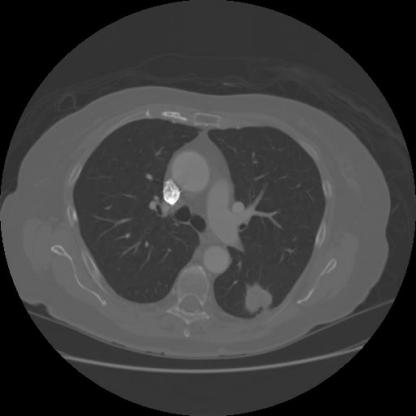

In [22]:
Image.open('/app/roboflow/train/images/LIDC-IDRI-0001_0_90_jpg.rf.170ce2dfe4b92cc2dde7134fd4fd7071.jpg')

In [48]:
ls /app/yolov5/runs/train/yolov5s_results22

confusion_matrix.png                                test_batch0_pred.jpg
events.out.tfevents.1635699843.e9ea4f0c832f.3387.0  test_batch1_labels.jpg
hyp.yaml                                            test_batch1_pred.jpg
labels.jpg                                          test_batch2_labels.jpg
labels_correlogram.jpg                              test_batch2_pred.jpg
opt.yaml                                            train_batch0.jpg
results.png                                         train_batch1.jpg
results.txt                                         train_batch2.jpg
test_batch0_labels.jpg                              weights/


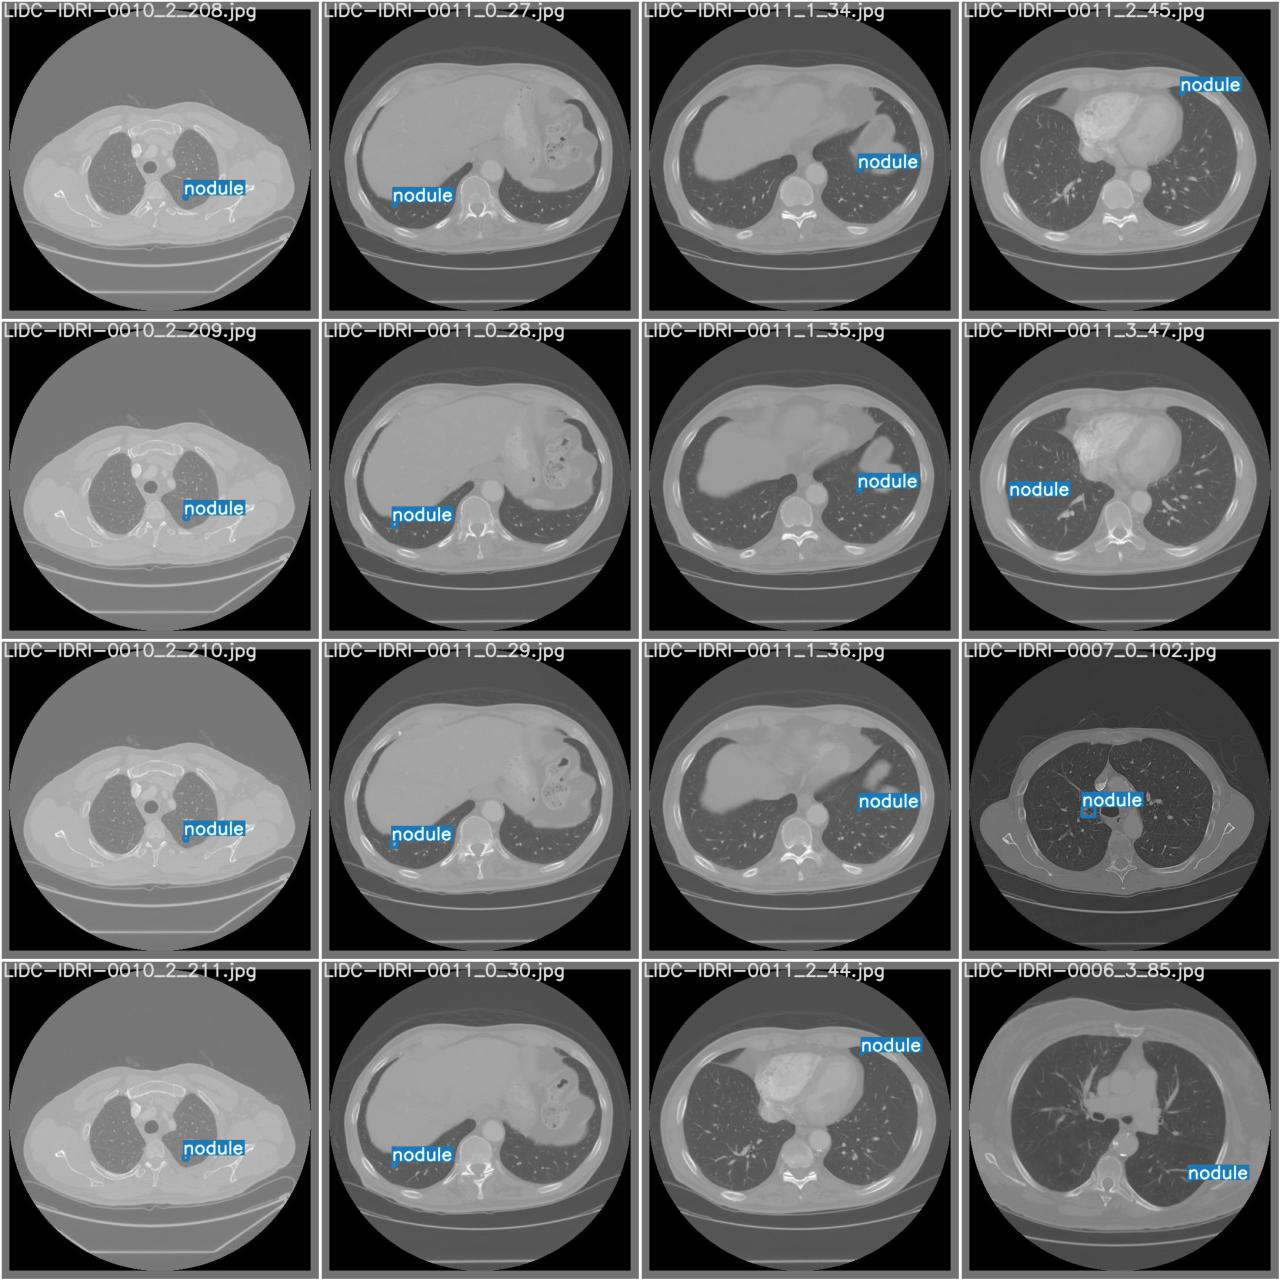

In [50]:
Image.open('/app/yolov5/runs/train/yolov5s_results22/test_batch2_labels.jpg')

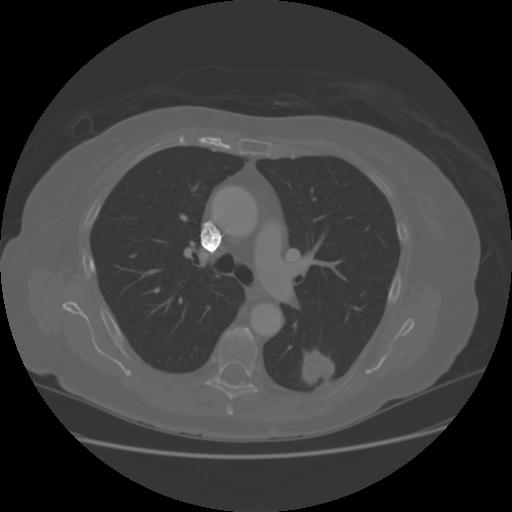

In [11]:
Image.open('/app/data/yolov5/train/images/LIDC-IDRI-0001_0_90.jpg')

In [143]:
ls /app/data/yolov5/train/images

LIDC-IDRI-0001_0_86.jpg   LIDC-IDRI-0003_2_84.jpg   LIDC-IDRI-0008_1_87.jpg
LIDC-IDRI-0001_0_87.jpg   LIDC-IDRI-0003_3_81.jpg   LIDC-IDRI-0008_1_88.jpg
LIDC-IDRI-0001_0_88.jpg   LIDC-IDRI-0003_3_82.jpg   LIDC-IDRI-0008_1_89.jpg
LIDC-IDRI-0001_0_89.jpg   LIDC-IDRI-0003_3_83.jpg   LIDC-IDRI-0009_0_102.jpg
LIDC-IDRI-0001_0_90.jpg   LIDC-IDRI-0003_3_84.jpg   LIDC-IDRI-0009_0_103.jpg
LIDC-IDRI-0001_0_91.jpg   LIDC-IDRI-0003_3_85.jpg   LIDC-IDRI-0009_0_104.jpg
LIDC-IDRI-0001_0_92.jpg   LIDC-IDRI-0003_3_86.jpg   LIDC-IDRI-0009_1_165.jpg
LIDC-IDRI-0001_0_93.jpg   LIDC-IDRI-0003_3_87.jpg   LIDC-IDRI-0009_1_166.jpg
LIDC-IDRI-0001_0_94.jpg   LIDC-IDRI-0003_3_88.jpg   LIDC-IDRI-0009_1_167.jpg
LIDC-IDRI-0002_0_171.jpg  LIDC-IDRI-0004_0_74.jpg   LIDC-IDRI-0009_1_168.jpg
LIDC-IDRI-0002_0_172.jpg  LIDC-IDRI-0004_0_75.jpg   LIDC-IDRI-0010_0_67.jpg
LIDC-IDRI-0002_0_173.jpg  LIDC-IDRI-0004_0_76.jpg   LIDC-IDRI-0010_0_68.jpg
LIDC-IDRI-0002_0_174.jpg  LIDC-IDRI-0004_0_77.jpg   LIDC-IDRI-0010_0_69.jpg
LIDC-

Loading dicom files ... This may take a moment.


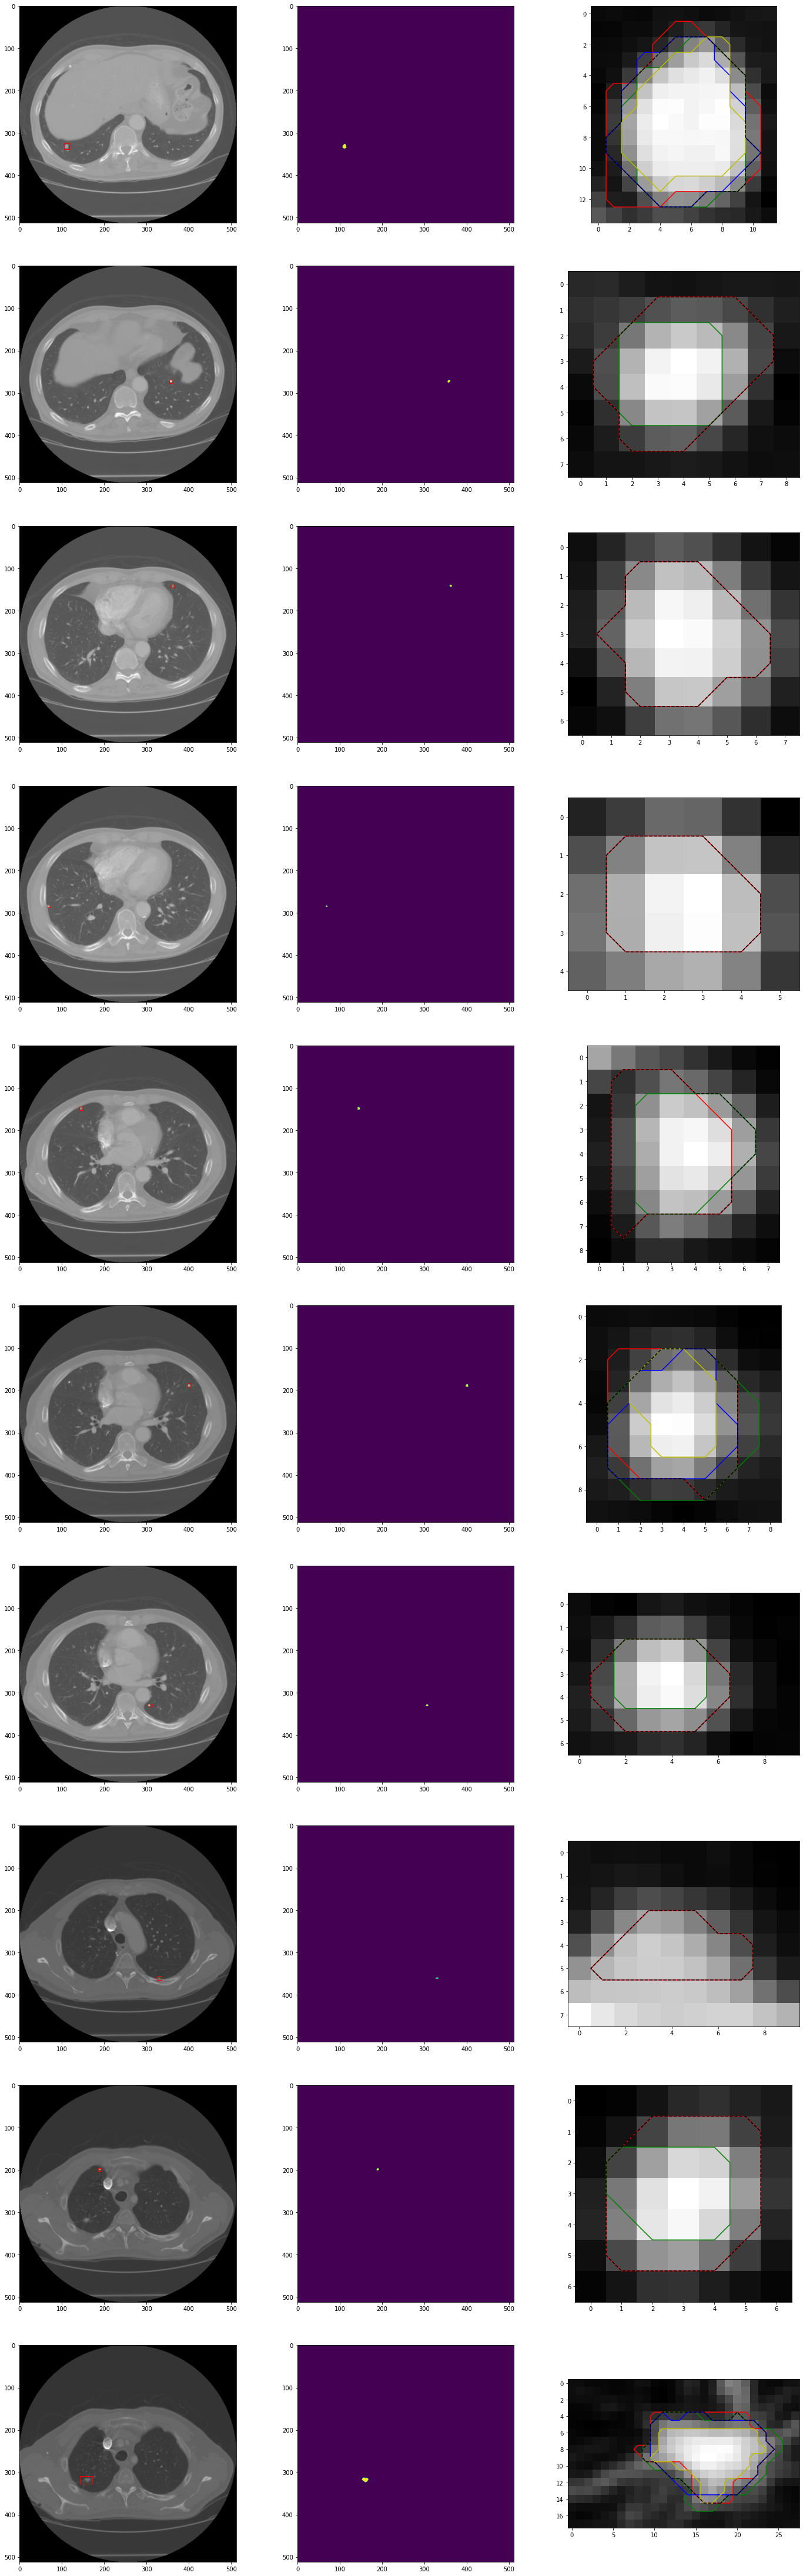

In [183]:
%matplotlib inline
import matplotlib.patches as patches
patient_select = 0
cohort = data_folder
patient_list = os.listdir(cohort)
patient_select = 0

#print ("Current patient ID =", patient_list[patient_select])
patient_list = ['LIDC-IDRI-0011']
scan = pl.query(pl.Scan).filter(pl.Scan.patient_id.in_(patient_list))
nodules_annotation = scan[patient_select].cluster_annotations()
vol = scan[patient_select].to_volume()

cmask_CT = []
cbbox_CT = []
masks_CT = []
for nodule_idx, nodule in enumerate(nodules_annotation):
    cmask, cbbox, masks = consensus(nodule)
    cmask_CT.append(cmask)
    cbbox_CT.append(cbbox)
    masks_CT.append(masks)   

nodule_num = len(cmask_CT)
plt.figure(figsize=(8*3,8*nodule_num))
for i in range(nodule_num):
    cmask = cmask_CT[i]
    cbbox = cbbox_CT[i]
    masks = masks_CT[i]
    k = int(0.5*(cbbox[2].stop - cbbox[2].start))
    k_slice = k + cbbox[2].start
    ax = plt.subplot(nodule_num,3,1+i*3)
    im1 = vol[:,:,k_slice]
    #im1 = Image.fromarray(im1)
    #im1 = im1.transpose(Image.FLIP_TOP_BOTTOM)
    #im1 = np.flip(im1, 0)
    #PIL.Image.FLIP_TOP_BOTTOM
    plt.imshow(im1,cmap='gray')
    #plt.clim(vmin=-1350,vmax=-150)
    
    x,y,z = cbbox
    rect = patches.Rectangle((y.start, x.start), (y.stop-y.start), (x.stop-x.start), linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    
    plt.subplot(nodule_num,3,2+i*3)
    CT_mask = np.zeros_like(vol)
    CT_mask[cbbox] = cmask
    plt.imshow(CT_mask[:,:,k_slice])

    plt.subplot(nodule_num,3,3+i*3)
    plt.imshow(vol[cbbox][:,:,k],cmap='gray')
    # Plot the annotation contours for the kth slice.
    colors = ['r', 'g', 'b', 'y']
    for j in range(len(masks)):
        for c in find_contours(masks[j][:,:,k].astype(float), 0.5):
            label = "Annotation %d" % (j+1)
            plt.plot(c[:,1], c[:,0], colors[j], label=label)

    # Plot the 50% consensus contour for the kth slice.
    for c in find_contours(cmask[:,:,k].astype(float), 0.5):
        plt.plot(c[:,1], c[:,0], '--k', label='50% Consensus')